In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import pearsonr

# Exploratory analysis

In this notebook we are going to focus on the `Expanded_data/big_data_final.tsv` dataset that is created by running the `data_creation.ipynb` notebook. Please refer to the data creation notebook for any questions concerning the construction of the dataset that we are using here.

We are going to display some relevant features and some preliminary analysis. But first, let's load the data.

In [2]:
df_movie = pd.read_csv("Expanded_data/big_data_final.tsv",sep='\t',low_memory=False)
print(df_movie.shape)
df_movie.head()

(9385367, 13)


,Freebase movie ID,IMDB_id,Movie box office revenue,Movie genres names,Movie name,Movie release date,averageRating,budget,numVotes,prod_country,inflation coeff,inflation corrected revenue,inflation corrected budget
0,/m/0100_m55,tt0138297,NaN,"['Comedy', 'Sci-Fi']",Urban Animals,1987.0,5.2,NaN,79.0,NaN,2.384772,NaN,NaN
1,/m/0100_mnm,tt0202813,NaN,['Comedy'],NaN,1999.0,5.8,NaN,15.0,NaN,1.626713,NaN,NaN
2,/m/0100_nzr,tt0184302,NaN,['Drama'],NaN,1999.0,4.8,NaN,119.0,NaN,1.626713,NaN,NaN
3,/m/0100_pgp,tt0094831,NaN,['Comedy'],NaN,1988.0,6.8,NaN,103.0,NaN,2.291337,NaN,NaN
4,/m/0100_pz9,tt0088884,NaN,['Comedy'],NaN,1985.0,2.4,NaN,59.0,NaN,2.519087,NaN,NaN


#### Dataset description, fill me please :)

- `Freebase movie ID`: 
- `IMDB_id`: 
- `Movie box office revenue`: 
- `Movie genres names`: 
- `Movie name`: 
- `Movie release date`: 
- `averageRating`: 
- `budget`: US dollar
- `numVotes`: 
- `prod_country`: 
- `inflation coeff`: 
- `inflation corrected revenue`: 
- `inflation corrected budget`:

In order to give an idea of how many movies are present per year, we can look at the distribution acorss the time

### Year distribution

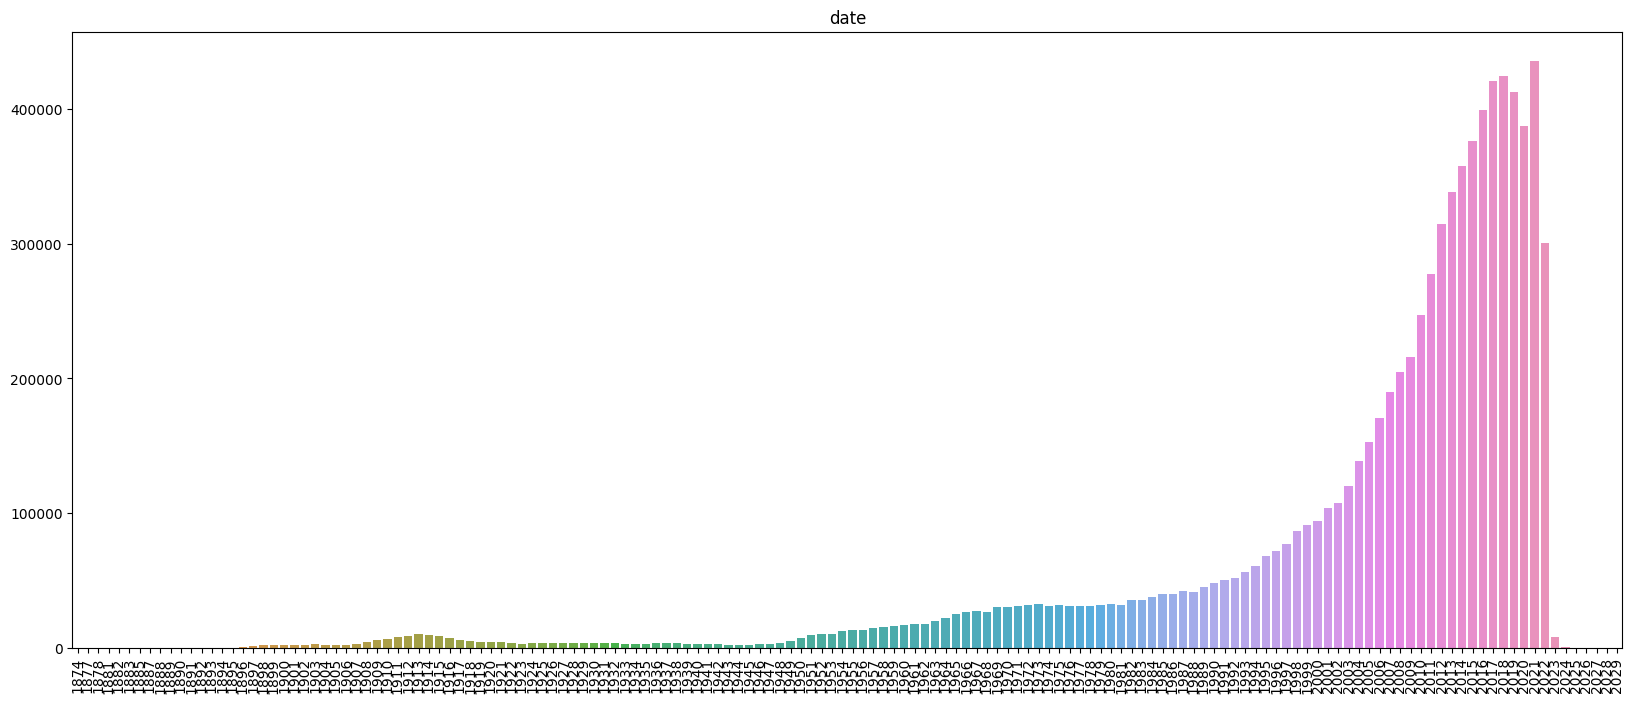

In [8]:
df_date = df_movie[~df_movie['Movie release date'].isna()]

count_per_year = df_date['Movie release date'].value_counts()
plt.figure(figsize=(20,8))
ax = sns.barplot(x=count_per_year.index.astype('int64'), y=count_per_year.values).set(title='date')
plt.xticks(rotation='vertical')
plt.show()

We remark that the dataset is not realistic when we approach to 2020. We should be careful if we want to draw conclusion from those years.
As we can expect we see that there is an exponential growth which starts around 1980

# 1) Rating, Revenue and Budget
To determine the success of a movie, we want to consider the box office revenue, the budget and the rating. Therefore, we have to analyse the relationship between these features. First of all we are going to focus on their distributions and the evolution across time. Then, we are going to compute the correlation coefficients between the variables.

The budgets and the revenues are corrected by considering the inflation. 

For each year there are several movies and therefore several ratings, revenues and budgets. We decided to average these variables for each year in order to get one single data point for each time point. But the mean hides a dark side, its sensitivity to outliers. This is why we are also going to compute the median values for each of the variable of interest. At the end of our analysis we are also going to consider the data without doing mean/median.

For all the test statistics we are going to use 5% as signifiant threshold.

### 1.1) An overview of the distributions

The inflation data start at 1959, therefore we are going to remove several movies.

In [3]:
dist = df_movie.copy()
dist = dist.dropna(subset=['inflation corrected budget','inflation corrected revenue','averageRating'])

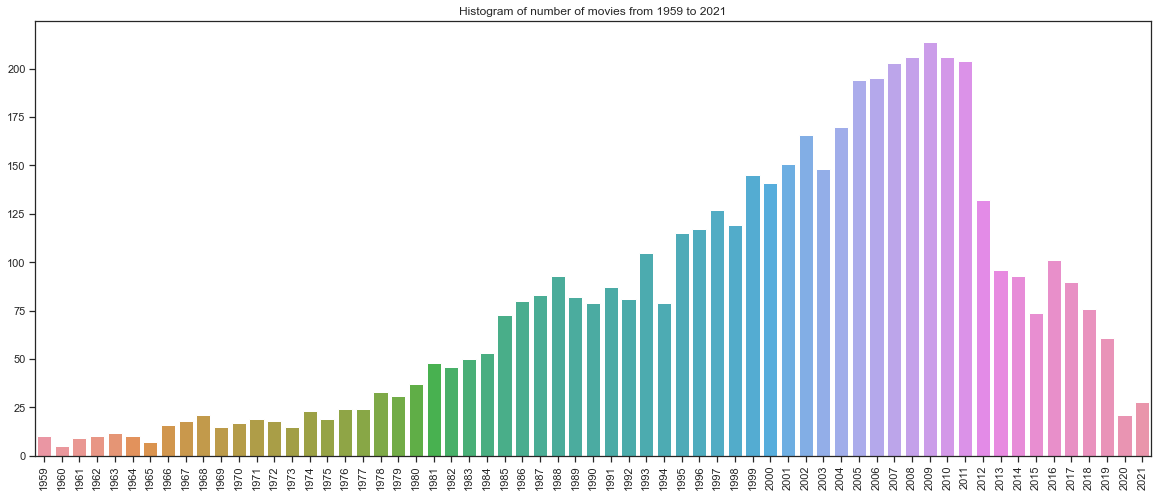

In [161]:
df_date = dist[~dist['Movie release date'].isna()]

count_per_year = df_date['Movie release date'].value_counts()
plt.figure(figsize=(20,8))
ax = sns.barplot(x=count_per_year.index.astype('int64'), y=count_per_year.values).set(title='date')
plt.xticks(rotation='vertical')
plt.title('Histogram of number of movies from 1959 to 2021')
plt.show()

The distribution above corresponds to the movie dataset that we are going to use across all the section 1.

Below we display the distributions of revenue, rating and budget (corrected with inflation whether it is necessary).
For the revenue we had to set boundaries to the x axis otherwise we would not have seen anything because of some huge outliers.
We remark that budget and revenue are heavy-tailed, therefore it is wise to use a log representation.

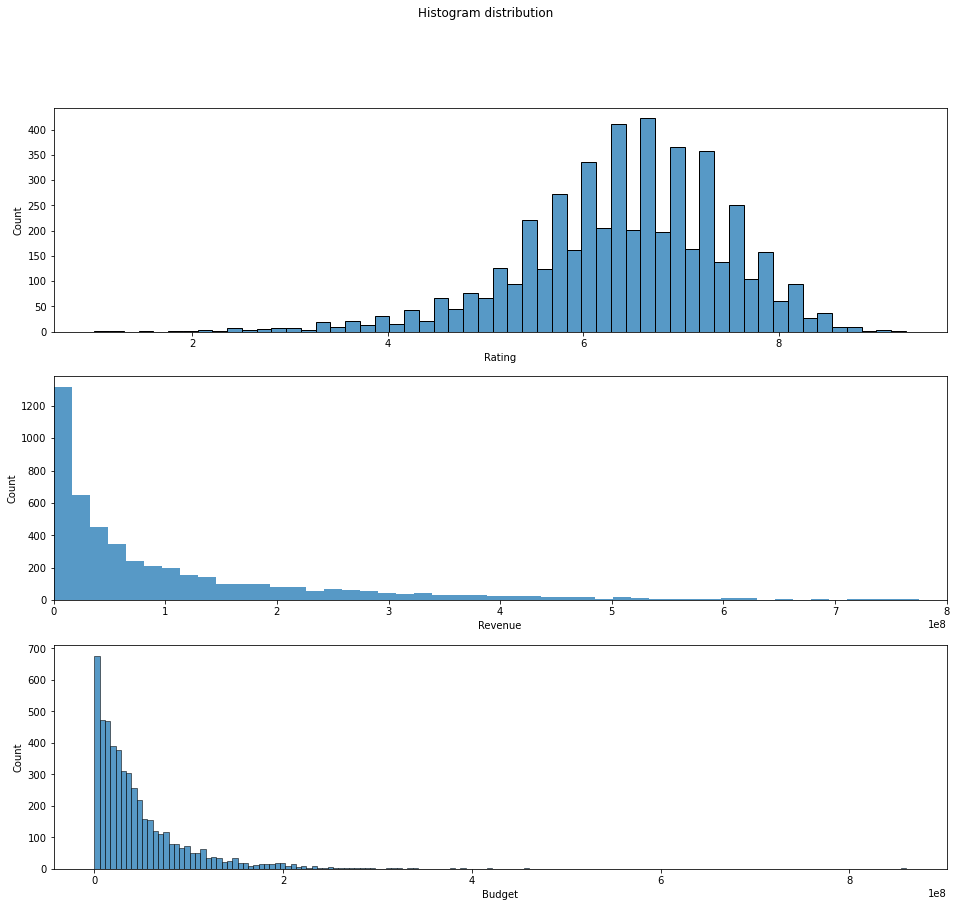

In [13]:
# Plotting
fig, axs = plt.subplots(3,1,figsize=(16,14))
sns.histplot(dist.averageRating,ax=axs[0])
sns.histplot(dist['inflation corrected revenue'],ax=axs[1])
axs[1].set_xlim([0,8e8])
sns.histplot(dist['inflation corrected budget'],ax=axs[2])
fig.suptitle('Histogram distribution')
axs[0].set_xlabel('Rating')
axs[1].set_xlabel('Revenue')
axs[2].set_xlabel('Budget')
plt.show()

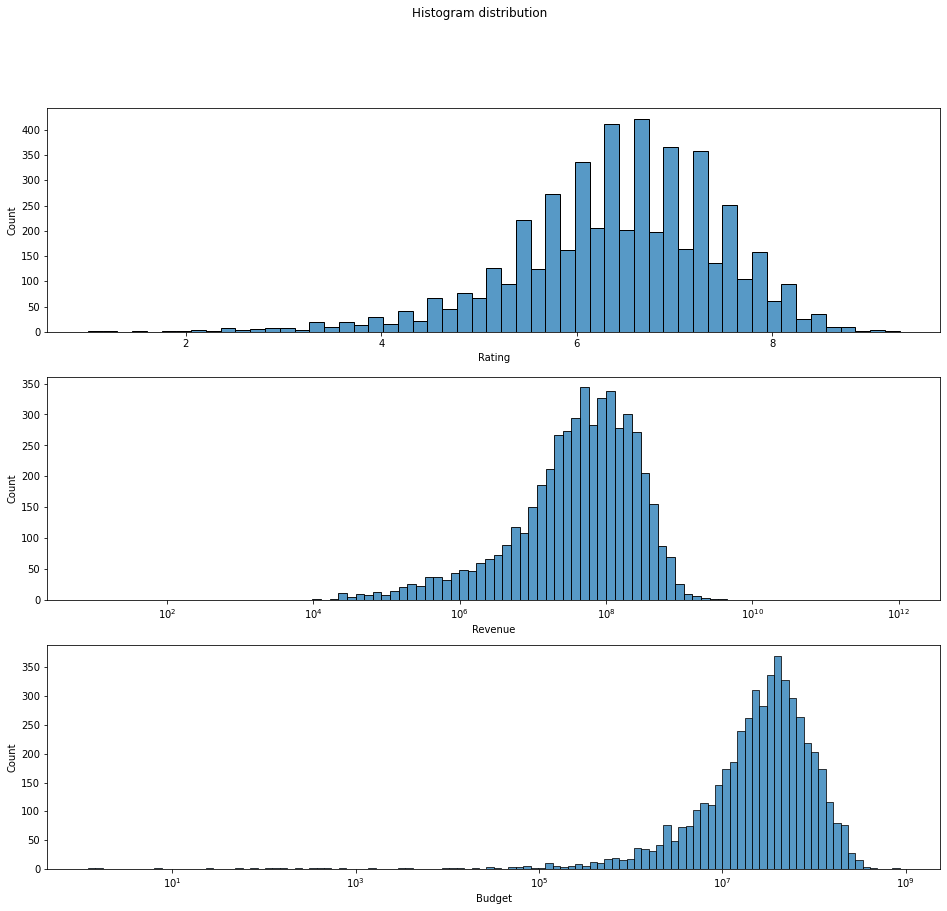

In [11]:
fig, axs = plt.subplots(3,1,figsize=(16,14))
sns.histplot(dist.averageRating,ax=axs[0])
sns.histplot(dist['inflation corrected revenue'],ax=axs[1],log_scale=[True,False])
sns.histplot(dist['inflation corrected budget'],ax=axs[2],log_scale=[True,False])
fig.suptitle('Histogram distribution')
axs[0].set_xlabel('Rating')
axs[1].set_xlabel('Revenue')
axs[2].set_xlabel('Budget')
plt.show()

### 1.2) An overview of revenue and budget with and without inflation

In this subsection we are going to show the difference between the data with and without inflation.

In [175]:
budget = df_movie.copy()
budget = budget.dropna(subset=['budget', 'inflation corrected budget'])

In [170]:
years = np.sort(budget['Movie release date'].unique())
mean_budget = np.zeros_like(years)
mean_budget_inf = np.zeros_like(years)
median_budget = np.zeros_like(years)
median_budget_inf = np.zeros_like(years)

for i,y in enumerate(years):
    
    bud = budget.loc[budget['Movie release date'] == y]['budget']
    bud_inf = budget.loc[budget['Movie release date'] == y]['inflation corrected budget']
    
    mean = np.mean(bud)
    median = np.median(bud)
    mean_budget[i] = mean
    median_budget[i] = median
    
    mean = np.mean(bud_inf)
    median = np.median(bud_inf)
    mean_budget_inf[i] = mean
    median_budget_inf[i] = median

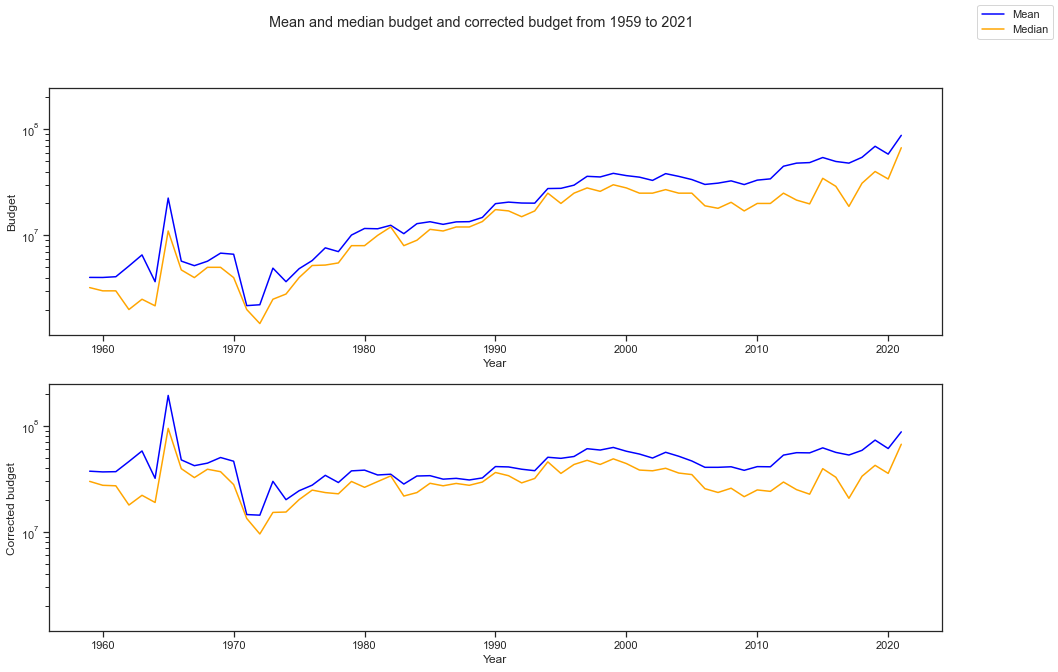

In [171]:
# Plotting
fig, ax = plt.subplots(2,1,figsize=(16,10),sharey=True)

ax[0].plot(years,mean_budget, color = 'blue', label='Mean')
ax[0].plot(years,median_budget, color = 'orange', label='Median')

ax[1].plot(years,mean_budget_inf, color = 'blue')
ax[1].plot(years,median_budget_inf, color = 'orange')

ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].set_ylabel('Budget')
ax[1].set_ylabel('Corrected budget')
ax[0].set_xlabel('Year')
ax[1].set_xlabel('Year')
plt.suptitle('Mean and median budget and corrected budget from 1959 to 2021')
fig.legend()
plt.show()

For the case of the budget, we see that without the correction there is a quite constant increasing from 1959 to 2021, even if there is an high variability. We remark that with the inflation there is a better stabilization. 

There is higher variability during the first years (1959-1973), which are probably due to the low number of movies during that years (around 10 for each year).

The same reasoning can be applied to the revenue, see plot below.

In both cases (budget, revenue), we see that the median value is below the mean value. It is likely that there are huge outliers  in the dataset.

In [152]:
revenue = df_movie.copy()
revenue = revenue.dropna(subset=['Movie box office revenue', 'inflation corrected revenue'])

In [155]:
years = np.sort(revenue['Movie release date'].unique())
mean_revenue = np.zeros_like(years)
mean_revenue_inf = np.zeros_like(years)
median_revenue = np.zeros_like(years)
median_revenue_inf = np.zeros_like(years)

for i,y in enumerate(years):
    
    rev = revenue.loc[revenue['Movie release date'] == y]['Movie box office revenue']
    rev_inf = revenue.loc[revenue['Movie release date'] == y]['inflation corrected revenue']
    
    mean = np.mean(rev)
    median = np.median(rev)
    mean_revenue[i] = mean
    median_revenue[i] = median
    
    mean = np.mean(rev_inf)
    median = np.median(rev_inf)
    mean_revenue_inf[i] = mean
    median_revenue_inf[i] = median

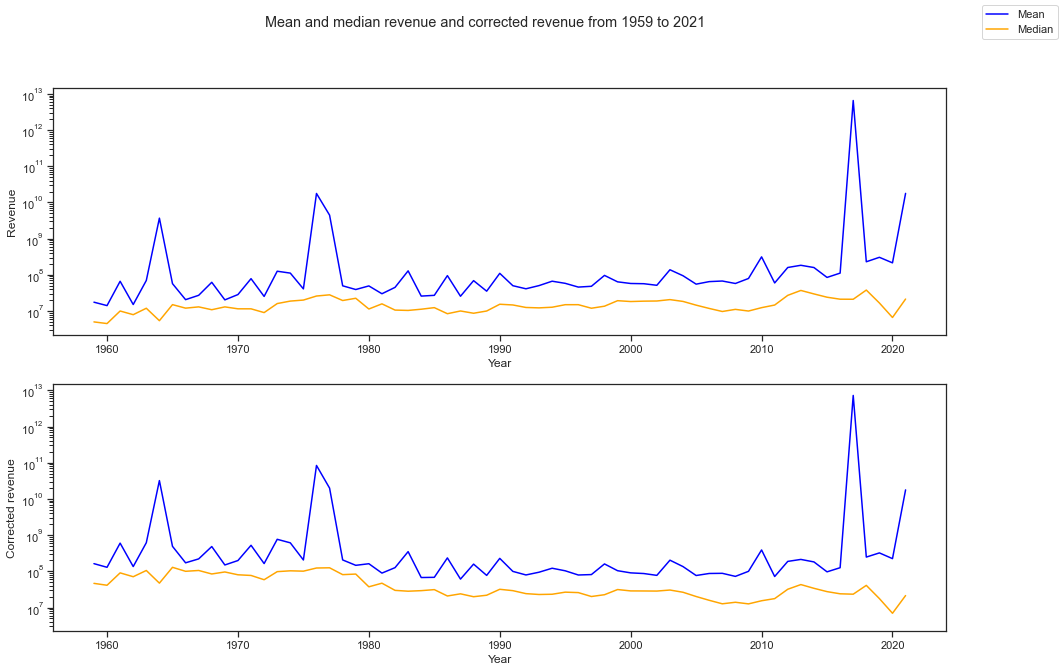

In [173]:
# Plotting
fig, ax = plt.subplots(2,1,figsize=(16,10),sharey=True)

ax[0].plot(years,mean_revenue, color = 'blue', label='Mean')
ax[0].plot(years,median_revenue, color = 'orange', label='Median')

ax[1].plot(years,mean_revenue_inf, color = 'blue')
ax[1].plot(years,median_revenue_inf, color = 'orange')

ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].set_ylabel('Revenue')
ax[1].set_ylabel('Corrected revenue')
ax[0].set_xlabel('Year')
ax[1].set_xlabel('Year')
plt.suptitle('Mean and median revenue and corrected revenue from 1959 to 2021')
fig.legend()
plt.show()

### 1.3) Rating, revenue and budget across time

We contruct a function that returns the mean, median and CI of both, with boostrap.

In [17]:
# Create the bootstrap function
def bootstrap(data, n_it):
    means = np.zeros(n_it)
    medians = np.zeros(n_it)
    data = np.array(data)
    
    for n in range(n_it):
        indices = np.random.randint(0, len(data), len(data))
        data_new = data[indices] 
        means[n] = np.nanmean(data_new)
        medians[n] = np.nanmedian(data_new)
    
    # 95% CI -> 2.5% and 97.5%
    return [np.nanmean(means), np.nanmedian(medians), np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5), np.nanpercentile(medians, 2.5),np.nanpercentile(medians, 97.5)]

In [18]:
#Revenue, Rating and Budget
df = df_movie.copy()
df = df.dropna(subset=['inflation corrected revenue', 'averageRating','inflation corrected budget'])

years = np.sort(df['Movie release date'].unique())

rev_mean, rev_median, rev_low, rev_high, rev_low_median, rev_high_median = np.zeros_like(years), np.zeros_like(years), np.zeros_like(years), np.zeros_like(years), np.zeros_like(years), np.zeros_like(years)
rat_mean, rat_median, rat_low, rat_high, rat_low_median, rat_high_median = np.zeros_like(years), np.zeros_like(years), np.zeros_like(years), np.zeros_like(years), np.zeros_like(years), np.zeros_like(years)
bud_mean, bud_median, bud_low, bud_high, bud_low_median, bud_high_median = np.zeros_like(years), np.zeros_like(years), np.zeros_like(years), np.zeros_like(years), np.zeros_like(years), np.zeros_like(years)


for i,y in enumerate(years):
    
    rev_mean[i], rev_median[i], rev_low[i], rev_high[i], rev_low_median[i], rev_high_median[i] = bootstrap(df.loc[df['Movie release date'] == y]['inflation corrected revenue'],1000)
    rat_mean[i], rat_median[i], rat_low[i], rat_high[i], rat_low_median[i], rat_high_median[i] = bootstrap(df.loc[df['Movie release date'] == y]['averageRating'],1000)
    bud_mean[i], bud_median[i], bud_low[i], bud_high[i], bud_low_median[i], bud_high_median[i] = bootstrap(df.loc[df['Movie release date'] == y]['inflation corrected budget'],1000)
    

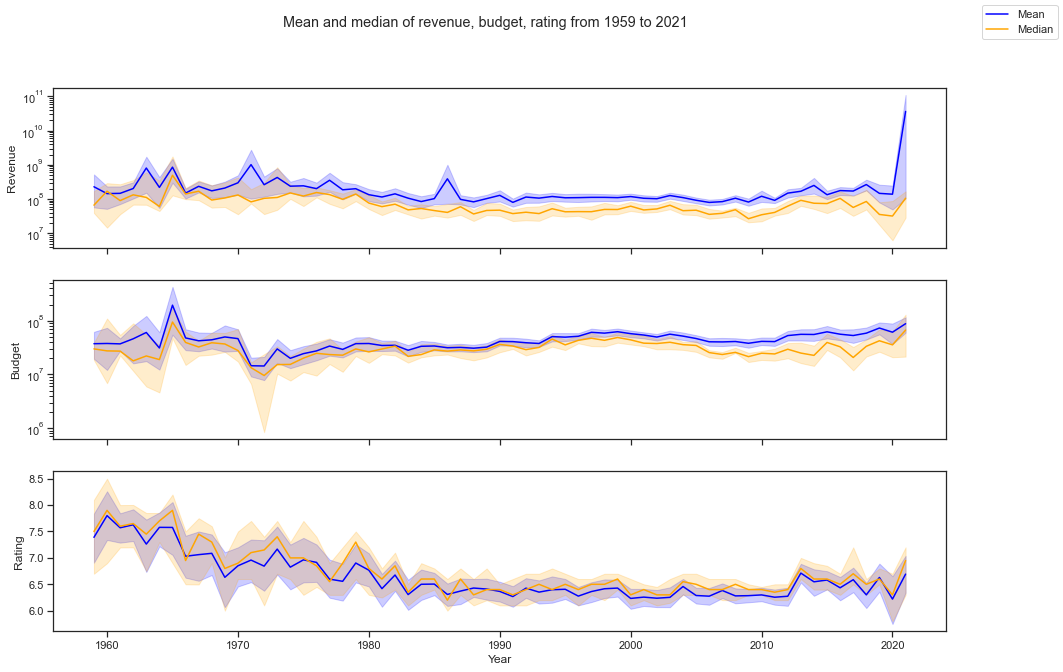

In [134]:
# Plotting
fig, ax = plt.subplots(3,1,figsize=(16,10),sharex=True)

ax[0].fill_between(years, rev_low,rev_high, alpha = 0.2, color = 'blue')
ax[0].plot(years,rev_mean, color = 'blue', label='Mean')

ax[0].fill_between(years, rev_low_median,rev_high_median, alpha = 0.2, color = 'orange')
ax[0].plot(years,rev_median, color = 'orange', label='Median')

ax[0].set_yscale('log')

ax[1].fill_between(years, bud_low,bud_high, alpha = 0.2, color = 'blue')
ax[1].plot(years,bud_mean, color = 'blue')

ax[1].fill_between(years, bud_low_median,bud_high_median, alpha = 0.2, color = 'orange')
ax[1].plot(years,bud_median, color = 'orange')

ax[1].set_yscale('log')

ax[2].fill_between(years, rat_low,rat_high, alpha = 0.2, color = 'blue')
ax[2].plot(years,rat_mean, color = 'blue')

ax[2].fill_between(years, rat_low_median,rat_high_median, alpha = 0.2, color = 'orange')
ax[2].plot(years,rat_median, color = 'orange')


ax[0].set_ylabel('Revenue')
ax[1].set_ylabel('Budget')
ax[2].set_ylabel('Rating')
plt.xlabel('Year')
plt.suptitle('Mean and median of revenue, budget, rating from 1959 to 2021')
fig.legend()
plt.show()

We remark again that the median is lower that the mean for the revenue and the budget.

### 1.4) Relationships between rating, revenue and budget

Here, we are going to compute the correlation coefficients between the features.

In [19]:
# Create a dataframe that will store our final result
df_pair = pd.DataFrame(columns=['Log revenue','Log budget','Rating','Type'])
df_pair['Log revenue'] = np.log(np.concatenate((rev_mean,rev_median)))
df_pair.Rating = np.concatenate((rat_mean,rat_median))
df_pair['Log budget'] = np.log(np.concatenate((bud_mean,bud_median)))

type_mean = np.empty(len(years), dtype='object')
type_mean.fill('Mean')
type_median = np.empty(len(years), dtype='object')
type_median.fill('Median')

df_pair.Type = np.concatenate((type_mean,type_median))

In [71]:
df_pair.head()

,Log revenue,Log budget,Rating,Type
0,19.229738,17.435793,7.398410,Mean
1,18.807822,17.431645,7.830200,Mean
2,18.842375,17.421410,7.574000,Mean
3,19.137185,17.647477,7.629380,Mean
4,20.502505,17.888562,7.264317,Mean


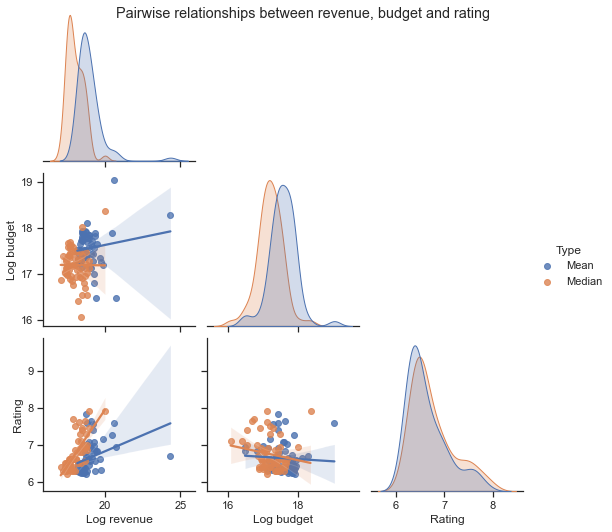

In [75]:
sns.set_theme(style="ticks")
rel = sns.pairplot(df_pair, hue="Type",kind='reg',corner=True)
rel.fig.suptitle('Pairwise relationships between revenue, budget and rating')
plt.show()

We remark that the median and the mean distributions of revenue and budget are different. The rating distributions are almost the same for the mean and the median

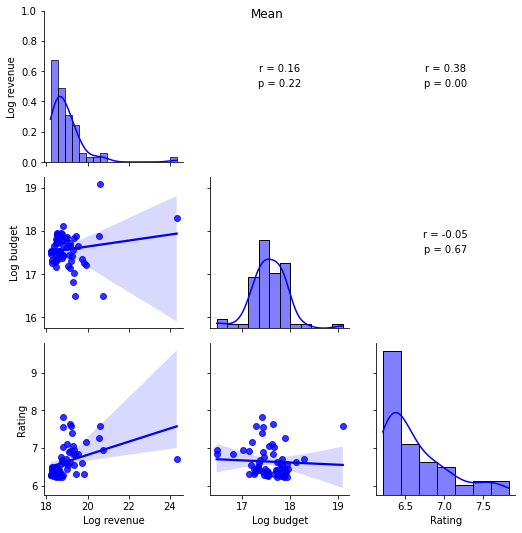

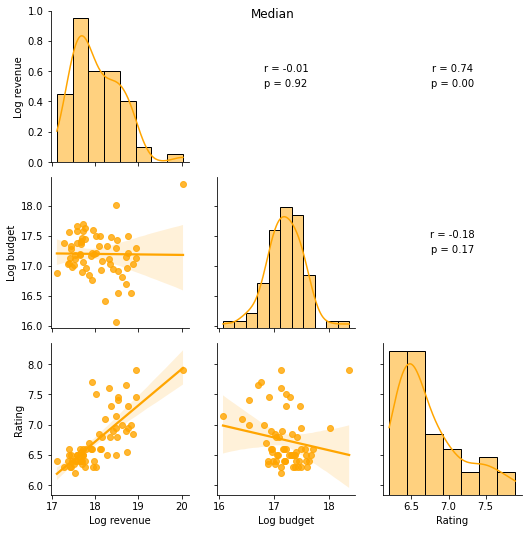

In [22]:
def reg_coef(x,y,label=None,color=None,**kwargs):
    ax = plt.gca()
    r,p = pearsonr(x,y)
    ax.annotate('r = {:.2f}'.format(r), xy=(0.5,0.6), xycoords='axes fraction', ha='center')
    ax.annotate('p = {:.2f}'.format(p), xy=(0.5,0.5), xycoords='axes fraction', ha='center')
    ax.set_axis_off()

g = sns.PairGrid(df_pair.loc[df_pair['Type']=='Mean'],hue='Type',palette=['blue'])
g.map_diag(sns.histplot,kde=True)
g.map_lower(sns.regplot)
g.map_upper(reg_coef)
g.fig.suptitle('Mean')

g = sns.PairGrid(df_pair.loc[df_pair['Type']=='Median'],hue='Type',palette=['orange'])
g.map_diag(sns.histplot,kde=True)
g.map_lower(sns.regplot)
g.map_upper(reg_coef)
g.fig.suptitle('Median')

plt.show()

If we look at the scatter plot matrix of the mean, we see that the only significant result is the one between the log revenue and rating, with a coefficient of around 0.38. It seems that the two are correlated.

If we look at the scatter plot matrix of the median, we see that again the only significant result is the one between the log revenue and rating, with a coefficient of around 0.74 this time. It seems that the two are strongly correlated.

If you want to look to the pearson coefficients with more digits:

In [ ]:
print(f'Pearson correlation between the log mean of revenue and the mean of rating: {stats.pearsonr(np.log(rev_mean),rat_mean)}')
print(f'Pearson correlation between the log median of revenue and the median of rating: {stats.pearsonr(np.log(rev_median),rat_median)}\n')

print(f'Pearson correlation between the log mean of revenue and the log mean of budget: {stats.pearsonr(np.log(rev_mean),np.log(bud_mean))}')
print(f'Pearson correlation between the log median of revenue and the log median of budget: {stats.pearsonr(np.log(rev_median),np.log(bud_median))}\n')

print(f'Pearson correlation between the mean of rating and the log mean of budget: {stats.pearsonr(rat_mean,np.log(bud_mean))}')
print(f'Pearson correlation between the median of rating and the log median of budget: {stats.pearsonr(rat_median,np.log(bud_median))}')

It may be interesting to look at the correlations without the log:

In [76]:
print(f'Pearson correlation between the mean of revenue and the mean of rating: {stats.pearsonr(rev_mean,rat_mean)}')
print(f'Pearson correlation between the median of revenue and the median of rating: {stats.pearsonr(rev_median,rat_median)}\n')

print(f'Pearson correlation between the mean of revenue and the mean of budget: {stats.pearsonr(rev_mean,bud_mean)}')
print(f'Pearson correlation between the median of revenue and the median of budget: {stats.pearsonr(rev_median,bud_median)}\n')

print(f'Pearson correlation between the mean of rating and the mean of budget: {stats.pearsonr(rat_mean,bud_mean)}')
print(f'Pearson correlation between the median of rating and the median of budget: {stats.pearsonr(rat_median,bud_median)}')

Pearson correlation between the mean of revenue and the mean of rating: (0.03661001955519833, 0.7757517062054972)
Pearson correlation between the median of revenue and the median of rating: (0.656364255081875, 5.210937903397796e-09)

Pearson correlation between the mean of revenue and the mean of budget: (0.2431652218321512, 0.05481415546653862)
Pearson correlation between the median of revenue and the median of budget: (0.42302313395023716, 0.000552139742803679)

Pearson correlation between the mean of rating and the mean of budget: (0.10826543584511711, 0.39832930912653225)
Pearson correlation between the median of rating and the median of budget: (-0.008739662481471622, 0.9458006944712314)


We now have the median revenue highly correlated with the median rating, but not as much as the log of the median revenue. In addition, we have a correlation between the median revenue and the median budget that we did not have with the log.

### 1.5) Relationships between rating, revenue and budget without mean/median across the year

It may also be interesting to look at all the values without averaging for each year. Therefore, I will to do the same analysis as in section 1.4).

In [40]:
alldata = df[['inflation corrected revenue','inflation corrected budget','averageRating']].copy()
alldata['inflation corrected revenue'] = alldata['inflation corrected revenue'].apply(np.log)
alldata['inflation corrected budget'] = alldata['inflation corrected budget'].apply(np.log)
alldata = alldata.rename(columns={'inflation corrected revenue':'Log inflation corrected revenue','inflation corrected budget':'Log inflation corrected budget','averageRating':'Rating'})

In [41]:
alldata.head()

,Log inflation corrected revenue,Log inflation corrected budget,Rating
33,15.361558,15.336866,7.6
231,19.411946,18.123773,7.0
465,14.027532,15.174347,6.7
491,20.227814,18.854661,8.0
518,18.997703,17.733576,7.8


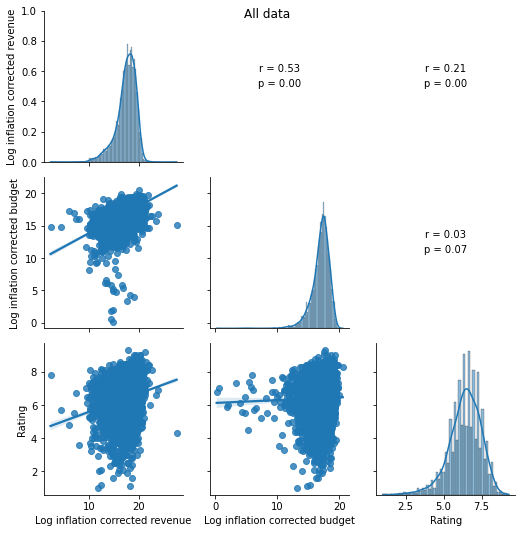

In [42]:
g = sns.PairGrid(alldata)
g.map_diag(sns.histplot,kde=True)
g.map_lower(sns.regplot)
g.map_upper(reg_coef)
g.fig.suptitle('All data')
plt.show()

From the plot above we remark that there is a significant correlation between log of the budget and the log of the revenue, and the rating and the log of revenue. More details are provided by the following cell: 

In [43]:
print('Pearson correlation between the log of revenue and the  rating:')
print(stats.pearsonr(np.log(df['inflation corrected revenue']),df['averageRating']))
print('Pearson correlation between the log of revenue and the log of budget:')
print(stats.pearsonr(np.log(df['inflation corrected revenue']),np.log(df['inflation corrected budget'])))
print('Pearson correlation between the rating and the log of budget:')
print(stats.pearsonr(df['averageRating'],np.log(df['inflation corrected budget'])))

Pearson correlation between the log of revenue and the  rating:
(0.20935996255960793, 6.931021240342771e-51)
Pearson correlation between the log of revenue and the log of budget:
(0.5259687975307819, 0.0)
Pearson correlation between the rating and the log of budget:
(0.0251999123847069, 0.074068287662638)


If we look at the same relations without the log we obtain:

In [44]:
print('Pearson correlation between the revenue and the  rating:')
print(stats.pearsonr(df['inflation corrected revenue'],df['averageRating']))
print('Pearson correlation between the revenue and the budget:')
print(stats.pearsonr(df['inflation corrected revenue'],df['inflation corrected budget']))
print('Pearson correlation between the rating and the budget:')
print(stats.pearsonr(df['averageRating'],df['inflation corrected budget']))

Pearson correlation between the revenue and the  rating:
(-0.02499066249497259, 0.07650171238467925)
Pearson correlation between the revenue and the budget:
(-0.006373817775516462, 0.6514746738274192)
Pearson correlation between the rating and the budget:
(0.05146397969403978, 0.0002625977993524644)


In this case we see that the only correlation that remains significant at a 5% level is the one between rating and budget, but the coefficient is soo small that we can neglect it.

# 2) See you at Milestone 3 :)